In [1]:
import cv2
import numpy as np
import os
import mediapipe as mp
import pandas as pd

In [2]:
if not os.path.exists('./dtw_sample_image'):
    os.mkdir('./dtw_sample_image')

In [3]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# train 영상으로 frame 별 skeleton 추출

In [4]:
cap = cv2.VideoCapture("./dtw_sample_train.mp4")

# video info
fps = cap.get(cv2.CAP_PROP_FPS)
delay = int(1000/fps)
print("height :", cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("width :", cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print("fps :", fps)

# create dataframe base
lv1 = [x.name for x in list(mp_pose.PoseLandmark)]
lv2 = ['x', 'y', 'z', 'v']
columns = pd.MultiIndex.from_product([lv1, lv2]).insert(0, ('playtime', 'sec'))
df = pd.DataFrame(columns=columns)

cnt = -1

# make mediapipe pose model
with mp_pose.Pose(static_image_mode=False,
                    model_complexity=1,
                    smooth_landmarks=True,
                    enable_segmentation=False,
                    smooth_segmentation=True,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5,) as pose:
    
    while cap.isOpened():
        
        ret, frame = cap.read()
        
        if not ret:
            break
        
        #playtime = round(cap.get(cv2.CAP_PROP_POS_MSEC)/1000, 2)
        
        # make skeleton image
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img.flags.writeable = False
        results = pose.process(img)
        img.flags.writeable = True
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        try:
            landmarks = results.pose_landmarks.landmark
            #print(landmarks)
        except:
            pass

        mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
        cv2.imshow("test", img)
        
        cnt += 1
        
        # save image & skeleton data
        #if cv2.waitKey(delay) & 0xFF == ord('c'):
        #if cnt % 30 == 0:
        cv2.imwrite(f"./dtw_sample_image/{cap.get(cv2.CAP_PROP_POS_FRAMES)}_train.jpg", img) #frame : 골격x / img : 골격o
        xyzv = np.array([[res.x, res.y, res.z, res.visibility]for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
        xyzv = np.insert(xyzv, 0, cap.get(cv2.CAP_PROP_POS_FRAMES))
        df = pd.concat([df, pd.DataFrame([xyzv], columns=columns)], ignore_index=True)
            #continue
        
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()
    df.to_csv("./dtw_sample_image/train_skeleton.csv", index=False) # save skeleton data

height : 720.0
width : 640.0
fps : 29.97002997002997


In [5]:
sk = pd.read_csv("./dtw_sample_image/train_skeleton.csv", header=[0,1])

In [6]:
sk.head()

playtime      NOSE                               LEFT_EYE_INNER            \
       sec         x         y         z         v              x         y   
0      1.0  0.530722  0.288515 -0.418072  0.999998       0.536021  0.274355   
1      2.0  0.531541  0.288517 -0.418771  0.999998       0.536534  0.274353   
2      3.0  0.531779  0.286608 -0.394940  0.999995       0.536731  0.272949   
3      4.0  0.532713  0.285407 -0.400416  0.999992       0.537325  0.271886   
4      5.0  0.533324  0.283762 -0.397750  0.999990       0.537871  0.270842   

                       LEFT_EYE  ... RIGHT_HEEL           LEFT_FOOT_INDEX  \
          z         v         x  ...          z         v               x   
0 -0.394486  0.999993  0.540506  ...   0.313760  0.885387        0.563856   
1 -0.394490  0.999992  0.540921  ...   0.398194  0.887266        0.564073   
2 -0.366800  0.999977  0.541114  ...   0.394549  0.888964        0.564106   
3 -0.371925  0.999959  0.541724  ...   0.379305  0.889909        0.564040   
4 -0.367384  0.999936  0.542315  ...   0.369387  0.891310        0.563863   

                                RIGHT_FOOT_INDEX                                
          y         z         v                x         y         z         v  
0  0.829309  0.148345  0.990084         0.507596  0.830114  0.134731  0.988936  
1  0.828517  0.252427  0.990203         0.507779  0.830136  0.222445  0.989117  
2  0.827820  0.262247  0.990189         0.507773  0.830136  0.215165  0.989273  
3  0.827544  0.244534  0.989954         0.507768  0.830144  0.196385  0.989313  
4  0.827439  0.222800  0.989689         0.507735  0.830162  0.185588  0.989340  

[5 rows x 133 columns]

# 관절들 사이의 각도 구하는 함수 생성

- 코사인 유사도 이용

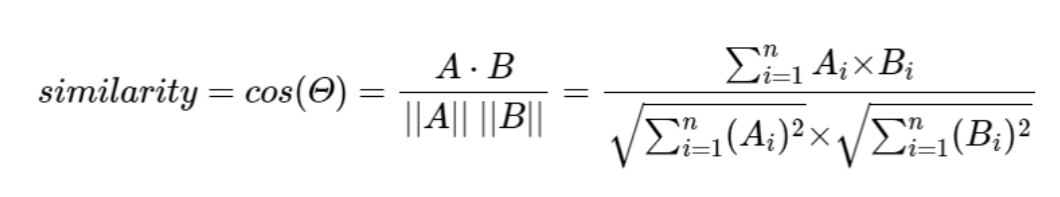

In [7]:
def cal_angle(a, b, c):
    ba = b - a
    bc = b - c

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))  # 코사인 유사도
    angle = np.arccos(cosine_angle)  # 라디안 값

    return angle

- 총 12개의 관절 각도(라디안)를 이용할 예정

    RIGHT_ELBOW : RIGHT_WRIST RIGHT_ELBOW RIGHT_SHOULDER
    RIGHT_SHOULDER1 : LEFT_SHOULDER RIGHT_SHOULDER RIGHT_HIP
    RIGHT_SHOULDER2 : RIGHT_ELBOW RIGHT_SHOULDER RIGHT_HIP
    RIGHT_HIP1 : RIGHT_SHOULDER RIGHT_HIP LEFT_HIP
    RIGHT_HIP2 : LEFT_HIP RIGHT_HIP RIGHT_KNEE
    RIGHT_KNEE : RIGHT_HIP RIGHT_KNEE RIGHT_ANKLE

    LEFT_ELBOW : LEFT_WRIST LEFT_ELBOW LEFT_SHOULDER
    LEFT_SHOULDER1 : RIGHT_SHOULDER LEFT_SHOULDER LEFT_HIP
    LEFT_SHOULDER2 : LEFT_ELBOW LEFT_SHOULDER LEFT_HIP
    LEFT_HIP1 : LEFT_SHOULDER LEFT_HIP RIGHT_HIP
    LEFT_HIP2 : RIGHT_HIP LEFT_HIP LEFT_KNEE
    LEFT_KNEE : LEFT_HIP LEFT_KNEE LEFT_ANKLE

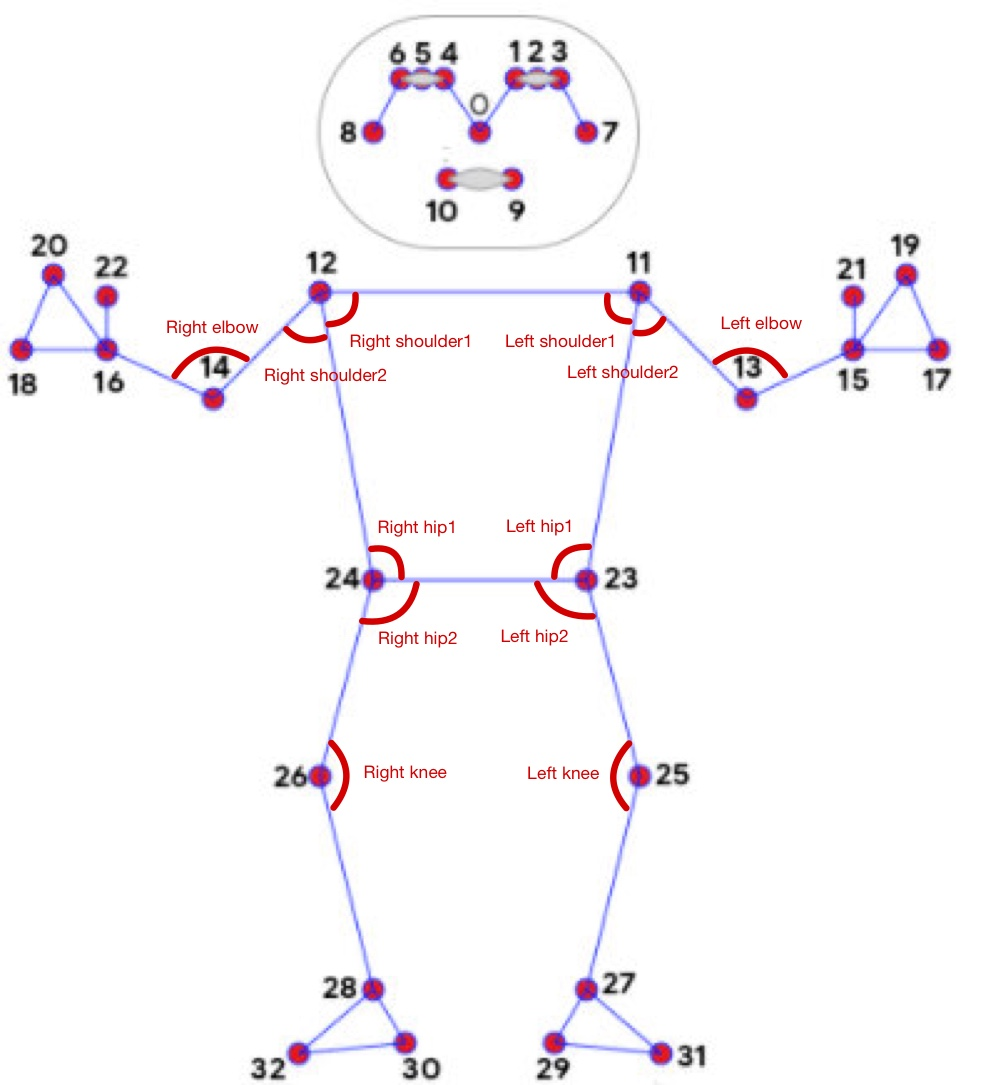

# train 영상으로 관절 각도 12개 생성

In [8]:
right_elbow = [cal_angle(sk['RIGHT_WRIST'].iloc[:, :3].iloc[n], 
               sk['RIGHT_ELBOW'].iloc[:, :3].iloc[n], 
               sk['RIGHT_SHOULDER'].iloc[:, :3].iloc[n]) for n in range(len(sk))]

right_shoulder1 = [cal_angle(sk['LEFT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk['RIGHT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk['RIGHT_HIP'].iloc[:, :3].iloc[n]) for n in range(len(sk))]

right_shoulder2 = [cal_angle(sk['RIGHT_ELBOW'].iloc[:, :3].iloc[n], 
               sk['RIGHT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk['RIGHT_HIP'].iloc[:, :3].iloc[n]) for n in range(len(sk))]

right_hip1 = [cal_angle(sk['RIGHT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk['RIGHT_HIP'].iloc[:, :3].iloc[n], 
               sk['LEFT_HIP'].iloc[:, :3].iloc[n]) for n in range(len(sk))]

right_hip2 = [cal_angle(sk['LEFT_HIP'].iloc[:, :3].iloc[n], 
               sk['RIGHT_HIP'].iloc[:, :3].iloc[n], 
               sk['RIGHT_KNEE'].iloc[:, :3].iloc[n]) for n in range(len(sk))]

right_knee = [cal_angle(sk['RIGHT_HIP'].iloc[:, :3].iloc[n], 
               sk['RIGHT_KNEE'].iloc[:, :3].iloc[n], 
               sk['RIGHT_ANKLE'].iloc[:, :3].iloc[n]) for n in range(len(sk))]


left_elbow = [cal_angle(sk['LEFT_WRIST'].iloc[:, :3].iloc[n], 
               sk['LEFT_ELBOW'].iloc[:, :3].iloc[n], 
               sk['LEFT_SHOULDER'].iloc[:, :3].iloc[n]) for n in range(len(sk))]

left_shoulder1 = [cal_angle(sk['RIGHT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk['LEFT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk['LEFT_HIP'].iloc[:, :3].iloc[n]) for n in range(len(sk))]

left_shoulder2 = [cal_angle(sk['LEFT_ELBOW'].iloc[:, :3].iloc[n], 
               sk['LEFT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk['LEFT_HIP'].iloc[:, :3].iloc[n]) for n in range(len(sk))]

left_hip1 = [cal_angle(sk['LEFT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk['LEFT_HIP'].iloc[:, :3].iloc[n], 
               sk['RIGHT_HIP'].iloc[:, :3].iloc[n]) for n in range(len(sk))]

left_hip2 = [cal_angle(sk['RIGHT_HIP'].iloc[:, :3].iloc[n], 
               sk['LEFT_HIP'].iloc[:, :3].iloc[n], 
               sk['LEFT_KNEE'].iloc[:, :3].iloc[n]) for n in range(len(sk))]

left_knee = [cal_angle(sk['LEFT_HIP'].iloc[:, :3].iloc[n], 
               sk['LEFT_KNEE'].iloc[:, :3].iloc[n], 
               sk['LEFT_ANKLE'].iloc[:, :3].iloc[n]) for n in range(len(sk))]

In [9]:
np.degrees(right_shoulder1[0])  # 첫 번째 frame의 right_shoulder 라디안 값을 각도로 변환해서 출력

83.67558679427619

# test 영상으로 frame 별 skeleton 추출

In [10]:
cap = cv2.VideoCapture("./dtw_sample_test.mp4")

# video info
fps = cap.get(cv2.CAP_PROP_FPS)
delay = int(1000/fps)
print("height :", cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("width :", cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print("fps :", fps)

# create dataframe base
lv1 = [x.name for x in list(mp_pose.PoseLandmark)]
lv2 = ['x', 'y', 'z', 'v']
columns = pd.MultiIndex.from_product([lv1, lv2]).insert(0, ('playtime', 'sec'))
df = pd.DataFrame(columns=columns)

cnt = -1

# make mediapipe pose model
with mp_pose.Pose(static_image_mode=False,
                    model_complexity=1,
                    smooth_landmarks=True,
                    enable_segmentation=False,
                    smooth_segmentation=True,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5,) as pose:
    
    while cap.isOpened():
        
        ret, frame = cap.read()
        
        if not ret:
            break
        
        #playtime = round(cap.get(cv2.CAP_PROP_POS_MSEC)/1000, 2)
        
        # make skeleton image
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img.flags.writeable = False
        results = pose.process(img)
        img.flags.writeable = True
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        try:
            landmarks = results.pose_landmarks.landmark
            #print(landmarks)
        except:
            pass

        mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
        cv2.imshow("test", img)
        
        cnt += 1
        
        # save image & skeleton data
        #if cv2.waitKey(delay) & 0xFF == ord('c'):
        #if cnt % 30 == 0:
        cv2.imwrite(f"./dtw_sample_image/{cap.get(cv2.CAP_PROP_POS_FRAMES)}_test.jpg", img) #frame : 골격x / img : 골격o
        xyzv = np.array([[res.x, res.y, res.z, res.visibility]for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
        xyzv = np.insert(xyzv, 0, cap.get(cv2.CAP_PROP_POS_FRAMES))
        df = pd.concat([df, pd.DataFrame([xyzv], columns=columns)], ignore_index=True)
            #continue
        
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()
    df.to_csv("./dtw_sample_image/test_skeleton.csv", index=False) # save skeleton data

height : 720.0
width : 640.0
fps : 29.97002997002997


In [11]:
sk2 = pd.read_csv('./dtw_sample_image/test_skeleton.csv', header=[0,1])

In [12]:
sk2.head()

playtime      NOSE                               LEFT_EYE_INNER            \
       sec         x         y         z         v              x         y   
0      1.0  0.517440  0.191790 -0.356848  0.999980       0.525520  0.180241   
1      2.0  0.515312  0.191814 -0.262179  0.999981       0.524741  0.180255   
2      3.0  0.511461  0.192231 -0.286979  0.999977       0.522251  0.180483   
3      4.0  0.509108  0.193643 -0.367301  0.999971       0.518850  0.181364   
4      5.0  0.508706  0.197692 -0.395361  0.999965       0.517989  0.185085   

                       LEFT_EYE  ... RIGHT_HEEL           LEFT_FOOT_INDEX  \
          z         v         x  ...          z         v               x   
0 -0.308863  0.999951  0.531481  ...   0.344362  0.927483        0.588020   
1 -0.212149  0.999953  0.530590  ...   0.303045  0.927459        0.587197   
2 -0.239952  0.999946  0.528537  ...   0.297698  0.927382        0.587022   
3 -0.323281  0.999933  0.525608  ...   0.299199  0.925959        0.585917   
4 -0.350740  0.999922  0.524685  ...   0.288224  0.925201        0.585518   

                                RIGHT_FOOT_INDEX                                
          y         z         v                x         y         z         v  
0  0.871516  0.022288  0.973722         0.435271  0.850148  0.137319  0.976482  
1  0.869676  0.032775  0.974414         0.434729  0.851558  0.092860  0.977257  
2  0.865889  0.038175  0.974965         0.432286  0.852560  0.086364  0.977879  
3  0.860315  0.043411  0.975676         0.433114  0.851815  0.085901  0.978507  
4  0.854297  0.046811  0.976267         0.433030  0.851337  0.069414  0.979128  

[5 rows x 133 columns]

# test 영상으로 관절 각도 12개 생성

In [13]:
test_right_elbow = [cal_angle(sk2['RIGHT_WRIST'].iloc[:, :3].iloc[n], 
               sk2['RIGHT_ELBOW'].iloc[:, :3].iloc[n], 
               sk2['RIGHT_SHOULDER'].iloc[:, :3].iloc[n]) for n in range(len(sk2))]
test_right_shoulder1 = [cal_angle(sk2['LEFT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk2['RIGHT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk2['RIGHT_HIP'].iloc[:, :3].iloc[n]) for n in range(len(sk2))]
test_right_shoulder2 = [cal_angle(sk2['RIGHT_ELBOW'].iloc[:, :3].iloc[n], 
               sk2['RIGHT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk2['RIGHT_HIP'].iloc[:, :3].iloc[n]) for n in range(len(sk2))]
test_right_hip1 = [cal_angle(sk2['RIGHT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk2['RIGHT_HIP'].iloc[:, :3].iloc[n], 
               sk2['LEFT_HIP'].iloc[:, :3].iloc[n]) for n in range(len(sk2))]
test_right_hip2 = [cal_angle(sk2['LEFT_HIP'].iloc[:, :3].iloc[n], 
               sk2['RIGHT_HIP'].iloc[:, :3].iloc[n], 
               sk2['RIGHT_KNEE'].iloc[:, :3].iloc[n]) for n in range(len(sk2))]
test_right_knee = [cal_angle(sk2['RIGHT_HIP'].iloc[:, :3].iloc[n], 
               sk2['RIGHT_KNEE'].iloc[:, :3].iloc[n], 
               sk2['RIGHT_ANKLE'].iloc[:, :3].iloc[n]) for n in range(len(sk2))]


test_left_elbow = [cal_angle(sk2['LEFT_WRIST'].iloc[:, :3].iloc[n], 
               sk2['LEFT_ELBOW'].iloc[:, :3].iloc[n], 
               sk2['LEFT_SHOULDER'].iloc[:, :3].iloc[n]) for n in range(len(sk2))]
test_left_shoulder1 = [cal_angle(sk2['RIGHT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk2['LEFT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk2['LEFT_HIP'].iloc[:, :3].iloc[n]) for n in range(len(sk2))]
test_left_shoulder2 = [cal_angle(sk2['LEFT_ELBOW'].iloc[:, :3].iloc[n], 
               sk2['LEFT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk2['LEFT_HIP'].iloc[:, :3].iloc[n]) for n in range(len(sk2))]
test_left_hip1 = [cal_angle(sk2['LEFT_SHOULDER'].iloc[:, :3].iloc[n], 
               sk2['LEFT_HIP'].iloc[:, :3].iloc[n], 
               sk2['RIGHT_HIP'].iloc[:, :3].iloc[n]) for n in range(len(sk2))]
test_left_hip2 = [cal_angle(sk2['RIGHT_HIP'].iloc[:, :3].iloc[n], 
               sk2['LEFT_HIP'].iloc[:, :3].iloc[n], 
               sk2['LEFT_KNEE'].iloc[:, :3].iloc[n]) for n in range(len(sk2))]
test_left_knee = [cal_angle(sk2['LEFT_HIP'].iloc[:, :3].iloc[n], 
               sk2['LEFT_KNEE'].iloc[:, :3].iloc[n], 
               sk2['LEFT_ANKLE'].iloc[:, :3].iloc[n]) for n in range(len(sk2))]

# fastdtw 로 시계열 유사도 비교

In [14]:
from fastdtw import fastdtw

In [15]:
tests = [test_right_elbow, 
test_right_shoulder1, 
test_right_shoulder2, 
test_right_hip1, 
test_right_hip2, 
test_right_knee, 
test_left_elbow, 
test_left_shoulder1, 
test_left_shoulder2, 
test_left_hip1, 
test_left_hip2, 
test_left_knee]

In [16]:
labels = [right_elbow, 
right_shoulder1, 
right_shoulder2, 
right_hip1, 
right_hip2, 
right_knee, 
left_elbow, 
left_shoulder1, 
left_shoulder2, 
left_hip1, 
left_hip2, 
left_knee]

In [17]:
dtw_results = [fastdtw(a,b)[0] for a, b in zip(labels, tests)]

In [18]:
dtw_results  # 관절 각도(라디안)별 dtw값 추출

[11.958590788696068,
 3.3554211766021127,
 8.098342225771354,
 2.455168801663861,
 3.934202003647486,
 2.9269074761005953,
 10.271354444841759,
 3.1174129357930864,
 7.841653632677578,
 2.478110235577089,
 1.939778957277143,
 10.32663745249695]

In [19]:
np.array(dtw_results).mean()

5.72529834426209

- dtw 값들의 평균을 점수화 시켜서 최종 score로 변환하는 작업 필요
- 아예 다른 영상을 가져와서 dtw의 mean값을 추출해보고 그 결과를 0점으로 처리
- dtw 값이 0일때를 완벽하게 일치한다고 판단하고 100점으로 처리
- 그 사이 값들을 점수화시키는 것에 대해 고민해보아야함